In [1]:
import pickle
import torch
from pathlib import Path
from easydict import EasyDict
import pandas as pd
from matplotlib import pyplot as plt
from ml import train
from dataloading import get_data, build_features, DataParser, MovingWindow
from tabulate import tabulate
from IPython.display import clear_output
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
import mplfinance as mpf
from sklearn.metrics import classification_report


%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [48]:
from utils import Position, Broker
from experts import PyConfig


cfg = PyConfig().test()

fsize=32

def load(folder):
    X, y, peaks = [], [], []
    hist_pd, hist = DataParser(cfg).load()
    mw = MovingWindow(hist, fsize) 
    for fname in sorted(Path(folder).rglob("*.xlsx")):
        df = pd.read_excel(fname)
        dates = [str(d.date()) for d in hist_pd.Date]
        f, _ = mw(dates.index(df.iloc[0].Date))
        dir = 1# if "max" in str(fname) else -1
        x = build_features(f, dir , None, None, None, None)
        X.append([x])
        lab_id = [1, 0] if "true" in str(fname) else [0, 1]
        y.append(lab_id)       
        
        df.Date = pd.to_datetime(df.Date)
        dt = np.array([(df.iloc[0].Date - df.iloc[i].Date).days for i in range(0, df.shape[0])])
        dy = [df.iloc[0].Close]
        dy += [df.iloc[i].High if df.iloc[i].Analyze == "real_peak_max" else df.iloc[i].Low for i in range(1, df.shape[0])]
        dy = (np.array(dy) - df.iloc[0].Close)/df.iloc[0].Close*100
        peaks.append([dt, dy])
    return X, np.array(y), peaks

In [ ]:
X, y, peaks = load("data/handmade_valid/")
X, y = np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

In [150]:
_, y_train, peaks_train = load("data/handmade_train/")
X_train = np.array(peaks_train.copy()).reshape((-1, 12))
train_ids = np.arange(y_train.shape[0])
np.random.shuffle(train_ids)
_, y_test, peaks_test = load("data/handmade_valid/")
X_test = np.array(peaks_test.copy()).reshape((-1, 12))
test_ids = np.arange(y_test.shape[0])
np.random.shuffle(test_ids)
print(X_train.shape, X_test.shape)

X_train, X_test, y_train, y_test = X_train[train_ids], X_test[test_ids], y_train[train_ids], y_test[test_ids]
print(sum(np.argmax(y_train, 1)==0), sum(np.argmax(y_test, 1)==0))

(612, 12) (92, 12)
163 13


In [511]:
X = np.array(peaks.copy()).reshape((-1, 12))
X.shape

(795, 12)

In [151]:
# test_half_size = int(0.2*y.shape[0]/2)
# ids = np.arange(y.shape[0])
# true_ids = ids[y[:, 0] == 1]
# false_ids = ids[y[:, 0] == 0]

# test_ids = np.hstack([true_ids[:test_half_size], false_ids[:test_half_size]])
# train_ids = np.hstack([true_ids[test_half_size:], false_ids[test_half_size:]])
# np.random.shuffle(train_ids)
# np.random.shuffle(test_ids)
# X_train, X_test, y_train, y_test = X[train_ids], X[test_ids], y[train_ids], y[test_ids]

X_train_aug = np.vstack([X_train]*1)
y_train_aug = np.vstack([y_train]*1)
# X_train_aug = np.ones_like(X_train_aug)*100
# X_train_aug *= (1 + (np.random.random(X_train_aug.shape) - 0.5)*1)
# X_train_aug[:, :6] = X_train_aug[:, :6].round(0)
print(X_train_aug.shape, X_test.shape)

(612, 12) (92, 12)


Text(0.5, 1.0, '[1 0]')

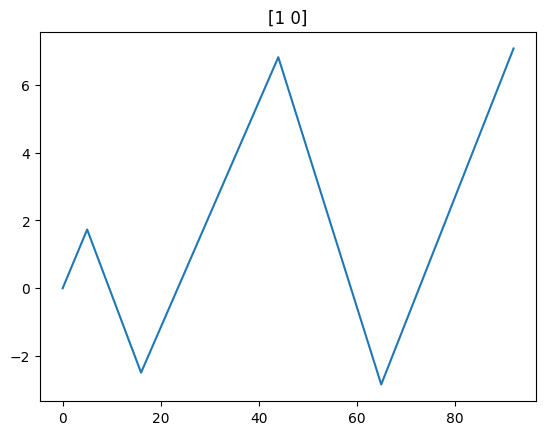

In [129]:
n = np.random.randint(500)
plt.plot(X_train_aug[n, :6], X_train_aug[n, 6:])
plt.title(y_train[n])

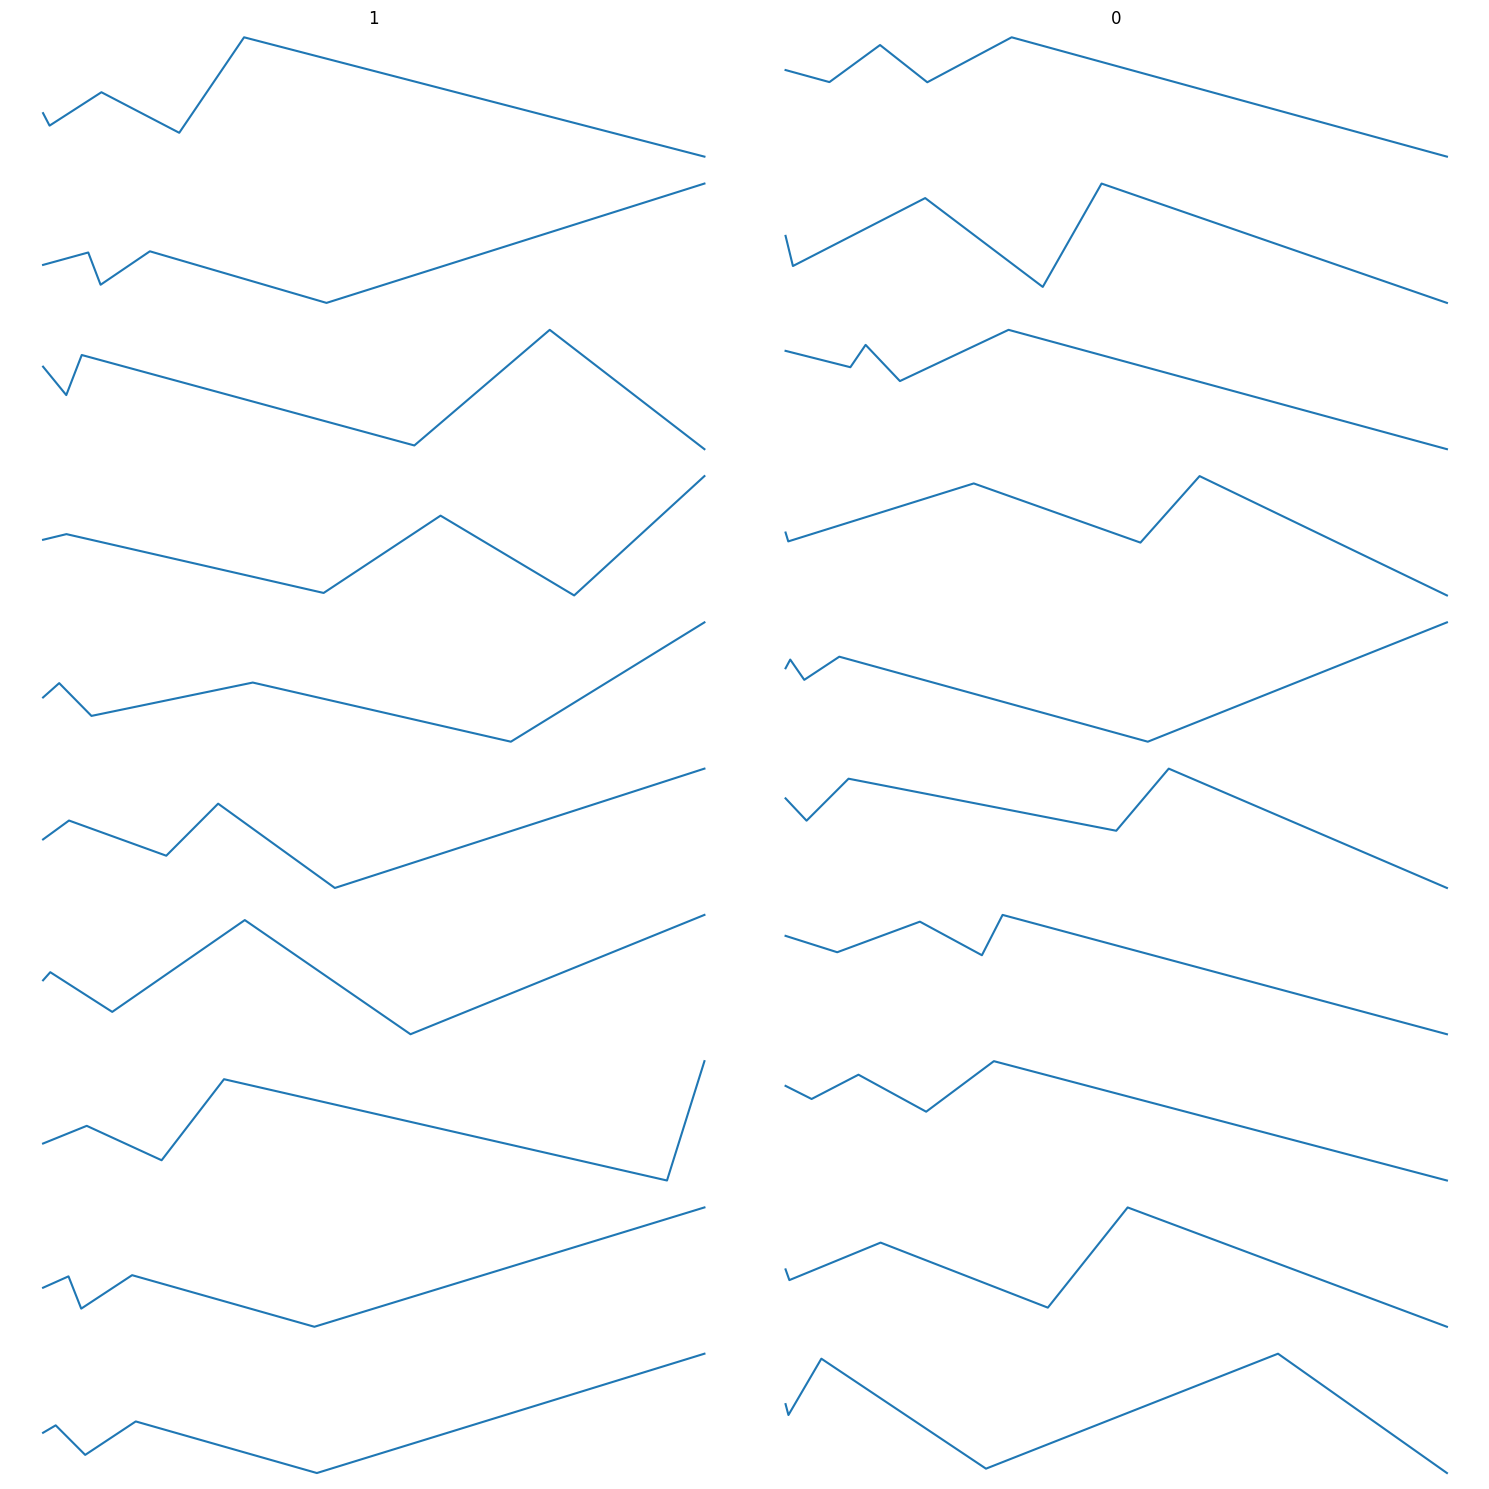

In [153]:
plt.subplots(figsize=(15, 15))
lab, nrow = 0, 0
for i in range(20):
    plt.subplot(10, 2, i+1)
    lab = 1 if lab == 0 else 0
    sample_id = true_ids[nrow] if lab == 1 else false_ids[nrow]
    plt.plot(X[sample_id][:6], X[sample_id][6:])
    plt.axis("off")
    if i < 2:
        plt.title(lab)
    plt.tight_layout()
    if i%2 == 0:
        nrow += 1
    # print(i, nrow, lab)

1.0 0.8684210526315789
              precision    recall  f1-score   support

           0       0.35      0.46      0.40        13
           1       0.90      0.84      0.87        79

   micro avg       0.80      0.78      0.79        92
   macro avg       0.63      0.65      0.63        92
weighted avg       0.83      0.78      0.80        92
 samples avg       0.78      0.78      0.78        92



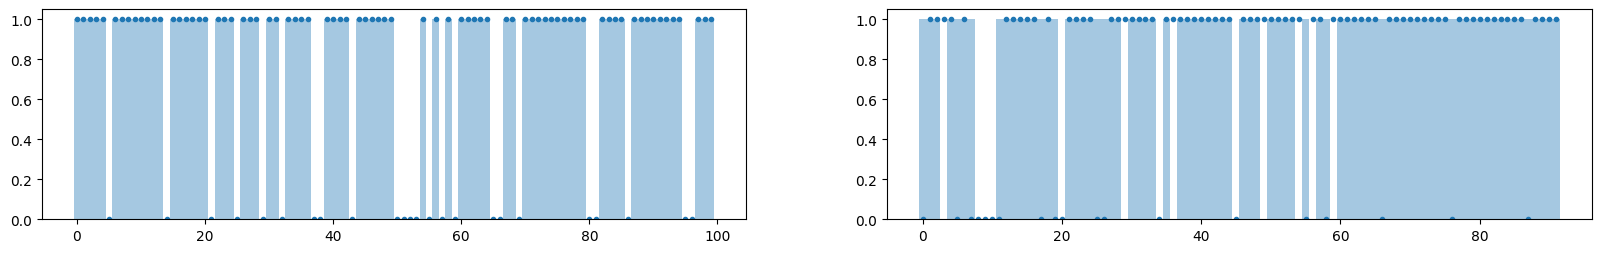

In [159]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(max_depth=15, n_estimators=50, class_weight="balanced")
model.fit(X_train_aug, y_train_aug)
p_train = np.array(model.predict_proba(X_train_aug))[1]
p_test = np.array(model.predict_proba(X_test))[1]

threshold = 0.5
p_train = p_train > threshold
p_test = p_test > threshold

metrics_train = f1_score(p_train.argmax(1), y_train_aug.argmax(1))
metrics_test = f1_score(p_test.argmax(1), y_test.argmax(1))
print(metrics_train, metrics_test)
plt.figure(figsize=(20, 6))
plt.subplot(2, 2, 1)
plt.plot(p_train[:100].argmax(1), ".")
plt.bar(np.arange(p_train[:100].shape[0]), y_train[:100].argmax(1), width=[1]*p_train[:100].shape[0], alpha=0.4)
if len(p_test):
    plt.subplot(2, 2, 2)
    plt.plot(p_test[:100].argmax(1), ".")
    plt.bar(np.arange(p_test[:100].shape[0]), y_test[:100].argmax(1), width=[1]*p_test[:100].shape[0], alpha=0.4)
print(classification_report(y_test, p_test))

In [160]:
sum(np.argmax(y_test, 1)==0), sum(np.argmax(y_test, 1)==1)

(13, 79)

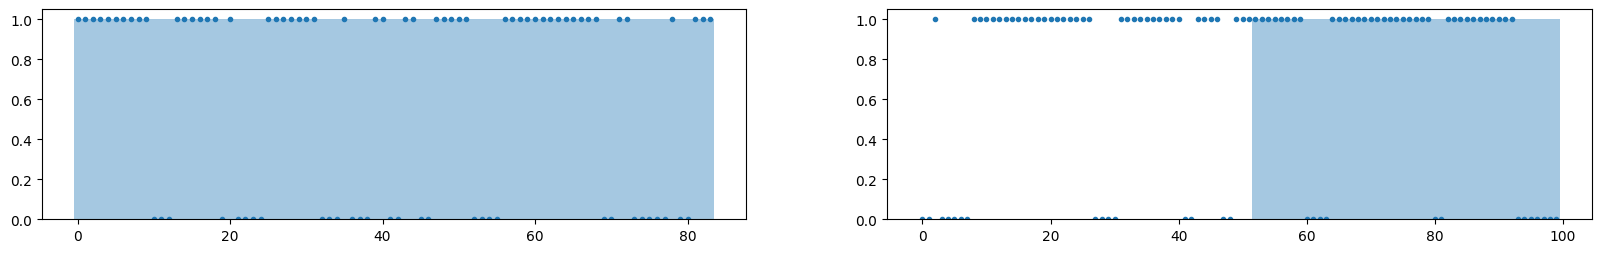

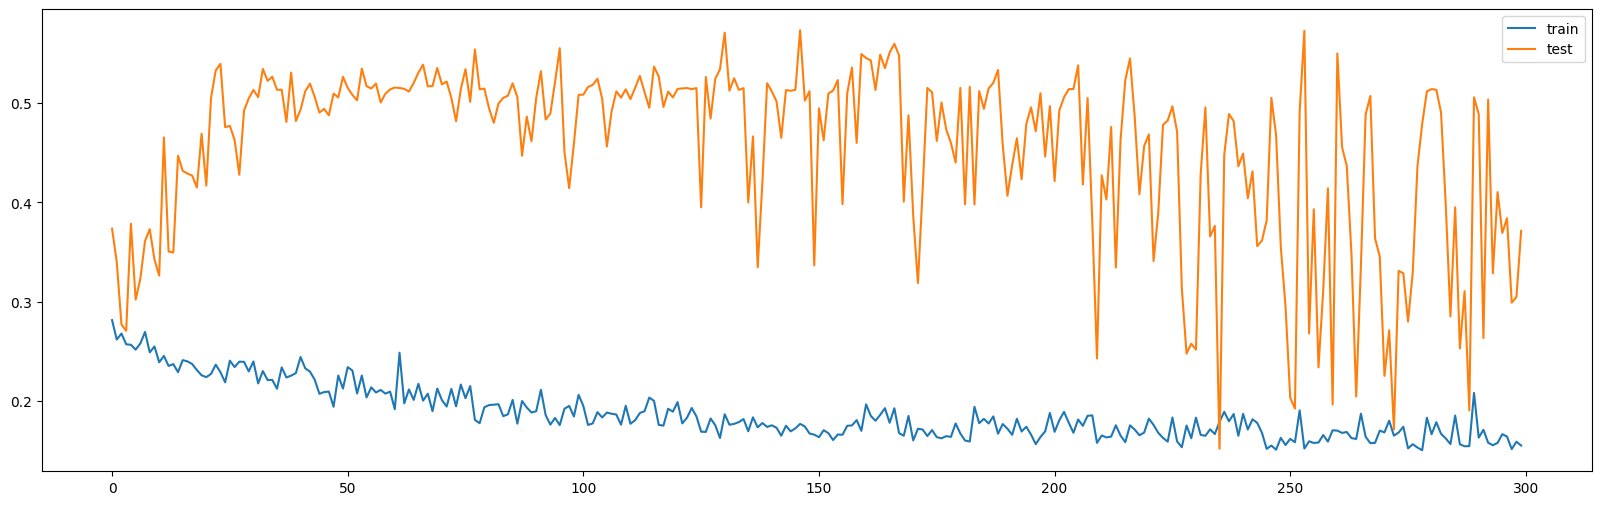

In [64]:
device = "mps"

calc_test = True

for i in range(1):
    X_train = torch.tensor(X_train).float().to(device)
    X_test = torch.tensor(X_test).float().to(device)
    # model, loss_hist = train(X_train, y_train, X_test, y_test, batch_size=128, epochs=300, device=device, calc_test=calc_test)
    model.eval()
    p_test = model.predict(X_test)
    p_train = model.predict(X_train)
        
plt.figure(figsize=(20, 6))
plt.subplot(2, 2, 1)
plt.plot(p_train[:100], ".")
plt.bar(np.arange(p_train[:100].shape[0]), y_train[:100].argmax(1), width=[1]*p_train[:100].shape[0], alpha=0.4)
if len(p_test):
    plt.subplot(2, 2, 2)
    plt.plot(p_test[:100], ".")
    plt.bar(np.arange(p_test[:100].shape[0]), y_test[:100].argmax(1), width=[1]*p_test[:100].shape[0], alpha=0.4)
plt.figure(figsize=(20, 6))
plt.plot(loss_hist)
plt.legend(["train", "test"])
torch.save(model.state_dict(), "model.pth")

In [65]:
print(classification_report(y_test.argmax(1), p_test, target_names=["correct", "wrong"]))

              precision    recall  f1-score   support

     correct       0.27      0.29      0.28        52
       wrong       0.71      0.69      0.70       133

    accuracy                           0.58       185
   macro avg       0.49      0.49      0.49       185
weighted avg       0.59      0.58      0.58       185



In [ ]:
import sys
from experts import ExpertFormation, PyConfig
from backtest import backtest
from pathlib import Path
from dataloading import get_data, collect_train_data
import numpy as np
from loguru import logger
from tqdm import tqdm
import torch
from ml import train
import matplotlib.pyplot as plt
logger.remove()
logger.add(sys.stderr, level="INFO")



test_split_size = 0.2
device = "mps"
cfg = PyConfig().test()
cfg.run_model_device = device

for _ in range(5):
    legend, last_prof = [], 0
    for i in range(int(1/test_split_size)):
        X_train, X_test, y_train, y_test, profs_train, profs_test, tf_test, test_dates = get_data(X, y, 1, test_split_size, i, i+1)
        X_train = torch.tensor(X_train).float().to(device)
        model, hist = train(X_train, y_train, None, None, batch_size=1024, epochs=10, device=device, calc_test=False)
        model.eval()
        # X_train = X_train.float().to(device)
        # p_train = model(X_train).detach().cpu().numpy().squeeze()[:, 0]    
        # profsum_best, threshold = -999999, np.percentile(p_train, 10)
        # for th in np.arange(0., 0.9, 0.025):
        #     profsum = f1_score(y_train[:, 0], p_train>th)
        #     if profsum > profsum_best:
        #         profsum_best = profsum
        #         threshold = th
        # model.set_threshold(threshold)
        torch.save(model.state_dict(), "model.pth")
        cfg.date_start=f"{test_dates[0][:4]}-{test_dates[0][4:6]}-{test_dates[0][6:]}"
        cfg.date_end=f"{test_dates[1][:4]}-{test_dates[1][4:6]}-{test_dates[1][6:]}"
        brok_results = backtest(cfg)
        cumsum = brok_results.profits.cumsum()
        print(brok_results.profits.sum())
        plt.plot([pos.close_date for pos in brok_results.positions], cumsum + last_prof)
        last_prof += cumsum[-1]
        plt.grid("on")
        plt.tight_layout()
        legend.append(f"{test_dates[0]}-{test_dates[1]}")

cfg.run_model_device = None
cfg.date_start="2004-01-01"
cfg.date_end="2024-01-01"
brok_results = backtest(cfg)
print(brok_results.profits.sum())
plt.plot([pos.close_date for pos in brok_results.positions], brok_results.profits.cumsum(), linewidth=3, alpha=0.6)
legend.append("baseline")
# plt.legend(legend)
plt.savefig("backtest.png")
# plt.show()

In [ ]:
import torch
from ml import Net
device = "cuda"
model = Net(7, 64)
model.load_state_dict(torch.load("model.pth"))
model.eval()
model.to(device)

In [ ]:
p = model.forward_thresholded(X_test)[:, 0]
w_profs_test = calc_weights(p_test[0], threshold)
pprofs_test = (profs_test*w_profs_test).sum(0)
pprofs_test, profs_test.sum()

In [ ]:
pprofs_sum1 = np.nansum(pprofits, 1)
gprofs_sum1 = np.nansum(gprofits, 1)
pprofs_sum1, gprofs_sum1, (pprofs_sum1-gprofs_sum1)/abs(gprofs_sum1)

In [ ]:
plt.plot(np.array(table)[:, 3], ".-")

In [ ]:
p_train.mean(), threshold

In [ ]:
import torch
from ml import Net
device = "cuda"
model = Net(7, 32)
model.load_state_dict(torch.load("model.pth"))
model.eval()
# model.set_threshold(-6)
model.to(device)
X_train, X_test, y_train, y_test, profs_train, profs_test, tf_test = get_data(X, y, test_split=1)
p_test = model(torch.tensor(X_test).float().to(device)).squeeze()
# profs_test.sum(), (profs_test*p_test).sum()
p_test

In [ ]:
X_train.shape

In [ ]:
list(model.named_parameters())[0]

In [ ]:
plt.plot(model(torch.tensor(X_test).float().to(device)).squeeze().detach().cpu().numpy())

In [ ]:
threshold

In [ ]:
y_test.sum(), (p_test>threshold).sum(), p_test.shape[0], y_test.shape[0]

In [ ]:
import mplfinance as mpf

ticker = "BTCUSDT"
tf = "H1"
hist_pd, hist = DataParser(
    EasyDict(
        date_start="2008-01-01",
        period=tf,
        ticker=ticker,
        data_type="bitfinex"
        )).load()

for i in ids_test:
    pos = poslist[i]
    if pos.ticker == ticker:
        prediction = model.predict_proba([X[i, :-1]])[0][1]
        if prediction < threshold:
            print(pos.ticker, pos.open_date, prediction)
            d2 = pd.to_datetime(pos.close_date)
            d1 = pd.to_datetime(pos.open_date)
            d0 = d1 - pd.DateOffset(days=3)
            hist2plot = hist_pd.loc[d0:d2]
            fig = mpf.plot(hist2plot, 
                type='candle', 
                block=False)

In [ ]:
prediction